In [1]:
import json
import os
import torch
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False
from torch.cuda import amp
from torch.utils.tensorboard import SummaryWriter
%load_ext autoreload
%autoreload 2 
# import radtts
import os
import json
from timeit import default_timer as timer
os.chdir('/usr/src/app/radtts')
from distributed import (init_distributed, apply_gradient_allreduce,
                         reduce_tensor)

from radtts import RADTTS
from train import RADTTSLoss, AttentionBinarizationLoss, prepare_dataloaders, prepare_model_weights, parse_data_from_batch, compute_validation_loss
import torch
# from radtts.inference import load_vocoder
from hifigan_env import AttrDict
from data import Data
from hifigan_models import Generator
from hifigan_env import AttrDict
from hifigan_denoiser import Denoiser
from radam import RAdam
torch.cuda.set_device(1)

# Needs to be here cause of implicit "config" argument
def prepare_output_folders_and_logger(output_directory):
    # Get shared output_directory ready
    if not os.path.isdir(output_directory):
        os.makedirs(output_directory)
        os.chmod(output_directory, 0o775)
        print("output directory", output_directory)

    output_config_path = os.path.join(output_directory, 'config.json')
    print("saving current configuration in output dir")
    config_fp = open(output_config_path, 'w')
    json.dump(config, config_fp, indent=4)
    config_fp.close()
    output_code_path = os.path.join(output_directory, 'code.tar.gz')
    os.system('tar -czvf %s *.py' % (output_code_path))

    tboard_out_path = os.path.join(output_directory, 'logs')
    print("setting up tboard log in %s" % (tboard_out_path))
    logger = SummaryWriter(tboard_out_path)
    return logger



In [2]:
config_path = '/usr/src/app/radtts/configs/2_22_23.json'
with open(config_path) as f:
    config = json.load(f)
seed = 1234

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
n_gpus = 1
train_config = config['train_config']
sigma = train_config['sigma']
model_config = config['model_config']
loss_weights = train_config['loss_weights']
learning_rate = train_config['learning_rate']
unfreeze_modules = train_config['unfreeze_modules']
weight_decay = train_config['weight_decay']
output_directory = train_config['output_directory']
use_amp = train_config['use_amp']
batch_size = 16
iters_per_checkpoint = train_config['iters_per_checkpoint']
grad_clip_val = train_config['grad_clip_val']
data_config = config['data_config']
epochs = train_config['epochs']
binarization_start_iter = train_config['binarization_start_iter']
criterion = RADTTSLoss(
    sigma,
    model_config['n_group_size'],
    model_config['dur_model_config'],
    model_config['f0_model_config'],
    model_config['energy_model_config'],
    vpred_model_config=model_config['v_model_config'],
    loss_weights=loss_weights
)
attention_kl_loss = AttentionBinarizationLoss()
model = RADTTS(**model_config).cuda()
rank = 0


Applying spectral norm to text encoder LSTM
Applying spectral norm to context encoder LSTM


/usr/src/app/radtts/common.py:391: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2349.)
  W = torch.qr(torch.FloatTensor(c, c).normal_())[0]
/opt/conda/lib/python3.8/site-packages/torch/functional.py:1682: UserWarning: torch.lu is deprecated in favor of torch.linalg.lu_factor / torch.linalg.lu_factor_ex and will be removed in a future PyTorch release.
LU, pivots = torch.lu(A, compute_pivots)
should be replaced with
LU, pivots = torch.linalg.lu_factor(A, compute_pivots)
and
LU, pivots, info = torch.lu(A, compute_pivots, get_infos=True)
should be replaced with
LU, pivots, info = torch.linalg.lu_factor_ex(A, compute_pivots) (Triggered internally at ../aten/src/ATen/n

In [8]:
from train import DataCollate
from torch.utils.data import DataLoader
def prepare_dataloaders(data_config, n_gpus, batch_size):
    # Get data, data loaders and collate function ready
    ignore_keys = ['training_files', 'validation_files']
    print("initializing training dataloader")
    trainset = Data(data_config['training_files'],
                    **dict((k, v) for k, v in data_config.items()
                    if k not in ignore_keys))

    print("initializing validation dataloader")
    data_config_val = data_config.copy()
    data_config_val['aug_probabilities'] = None  # no aug in val set
    valset = Data(data_config['validation_files'],
                  **dict((k, v) for k, v in data_config_val.items()
                  if k not in ignore_keys), speaker_ids=trainset.speaker_ids)

    collate_fn = DataCollate()

    train_sampler, shuffle = None, True
    if n_gpus > 1:
        train_sampler, shuffle = DistributedSampler(trainset), False

    train_loader = DataLoader(trainset, num_workers=8, shuffle=shuffle,
                              sampler=train_sampler, batch_size=batch_size,
                              pin_memory=False, drop_last=True,
                              collate_fn=collate_fn)

    return train_loader, valset, collate_fn, trainset

In [9]:
iteration = 0
optimizer = RAdam(model.parameters(), lr=learning_rate,
                      weight_decay=weight_decay)

scaler = amp.GradScaler(enabled=use_amp)

for param_group in optimizer.param_groups:
    param_group['lr'] = learning_rate

train_loader, valset, collate_fn, trainset = prepare_dataloaders(
    data_config, n_gpus, batch_size)

logger = prepare_output_folders_and_logger(output_directory)

prepare_model_weights(model, unfreeze_modules)
model.train()

epoch_offset = 0

initializing training dataloader
Number of speakers: 30
Speaker IDS {'0': 0, '1': 1, '10': 2, '11': 3, '12': 4, '13': 5, '14': 6, '15': 7, '16': 8, '17': 9, '18': 10, '19': 11, '2': 12, '20': 13, '21': 14, '22': 15, '23': 16, '24': 17, '25': 18, '26': 19, '27': 20, '28': 21, '29': 22, '3': 23, '4': 24, '5': 25, '6': 26, '7': 27, '8': 28, '9': 29}
Number of files 21855
Number of files after duration filtering 21855
Dataloader initialized with no augmentations
initializing validation dataloader
Number of files 21855
Number of files after duration filtering 21855
Dataloader initialized with no augmentations
saving current configuration in output dir
setting up tboard log in /usr/src/app/radtts/outputs/2_22_23/logs
Training everything


In [13]:
for i in range(10000,21855):
    print(i)
    trainset.__getitem__(i)

10000
10001
10002
10003
10004
10005
10006
10007
10008
10009
10010
10011
10012
10013
10014
10015
10016
10017
10018
10019
10020
10021
10022
10023
10024
10025
10026
10027
10028
10029
10030
10031
10032
10033
10034
10035
10036
10037
10038
10039
10040
10041
10042
10043
10044
10045
10046
10047
10048
10049
10050
10051
10052
10053
10054
10055
10056
10057
10058
10059
10060
10061
10062
10063
10064
10065
10066
10067
10068
10069
10070
10071
10072
10073
10074
10075
10076
10077
10078
10079
10080
10081
10082
10083
10084
10085
10086
10087
10088
10089
10090
10091
10092
10093
10094
10095
10096
10097
10098
10099
10100
10101
10102
10103
10104
10105
10106
10107
10108
10109
10110
10111
10112
10113
10114
10115
10116
10117
10118
10119
10120
10121
10122
10123
10124
10125
10126
10127
10128
10129
10130
10131
10132
10133
10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
10163
10164
10165
1016

11404
11405
11406
11407
11408
11409
11410
11411
11412
11413
11414
11415
11416
11417
11418
11419
11420
11421
11422
11423
11424
11425
11426
11427
11428
11429
11430
11431
11432
11433
11434
11435
11436
11437
11438
11439
11440
11441
11442
11443
11444
11445
11446
11447
11448
11449
11450
11451
11452
11453
11454
11455
11456
11457
11458
11459
11460
11461
11462
11463
11464
11465
11466
11467
11468
11469
11470
11471
11472
11473
11474
11475
11476
11477
11478
11479
11480
11481
11482
11483
11484
11485
11486
11487
11488
11489
11490
11491
11492
11493
11494
11495
11496
11497
11498
11499
11500
11501
11502
11503
11504
11505
11506
11507
11508
11509
11510
11511
11512
11513
11514
11515
11516
11517
11518
11519
11520
11521
11522
11523
11524
11525
11526
11527
11528
11529
11530
11531
11532
11533
11534
11535
11536
11537
11538
11539
11540
11541
11542
11543
11544
11545
11546
11547
11548
11549
11550
11551
11552
11553
11554
11555
11556
11557
11558
11559
11560
11561
11562
11563
11564
11565
11566
11567
11568
11569
1157

12781
12782
12783
12784
12785
12786
12787
12788
12789
12790
12791
12792
12793
12794
12795
12796
12797
12798
12799
12800
12801
12802
12803
12804
12805
12806
12807
12808
12809
12810
12811
12812
12813
12814
12815
12816
12817
12818
12819
12820
12821
12822
12823
12824
12825
12826
12827
12828
12829
12830
12831
12832
12833
12834
12835
12836
12837
12838
12839
12840
12841
12842
12843
12844
12845
12846
12847
12848
12849
12850
12851
12852
12853
12854
12855
12856
12857
12858
12859
12860
12861
12862
12863
12864
12865
12866
12867
12868
12869
12870
12871
12872
12873
12874
12875
12876
12877
12878
12879
12880
12881
12882
12883
12884
12885
12886
12887
12888
12889
12890
12891
12892
12893
12894
12895
12896
12897
12898
12899
12900
12901
12902
12903
12904
12905
12906
12907
12908
12909
12910
12911
12912
12913
12914
12915
12916
12917
12918
12919
12920
12921
12922
12923
12924
12925
12926
12927
12928
12929
12930
12931
12932
12933
12934
12935
12936
12937
12938
12939
12940
12941
12942
12943
12944
12945
12946
1294

14152
14153
14154
14155
14156
14157
14158
14159
14160
14161
14162
14163
14164
14165
14166
14167
14168
14169
14170
14171
14172
14173
14174
14175
14176
14177
14178
14179
14180
14181
14182
14183
14184
14185
14186
14187
14188
14189
14190
14191
14192
14193
14194
14195
14196
14197
14198
14199
14200
14201
14202
14203
14204
14205
14206
14207
14208
14209
14210
14211
14212
14213
14214
14215
14216
14217
14218
14219
14220
14221
14222
14223
14224
14225
14226
14227
14228
14229
14230
14231
14232
14233
14234
14235
14236
14237
14238
14239
14240
14241
14242
14243
14244
14245
14246
14247
14248
14249
14250
14251
14252
14253
14254
14255
14256
14257
14258
14259
14260
14261
14262
14263
14264
14265
14266
14267
14268
14269
14270
14271
14272
14273
14274
14275
14276
14277
14278
14279
14280
14281
14282
14283
14284
14285
14286
14287
14288
14289
14290
14291
14292
14293
14294
14295
14296
14297
14298
14299
14300
14301
14302
14303
14304
14305
14306
14307
14308
14309
14310
14311
14312
14313
14314
14315
14316
14317
1431

15539
15540
15541
15542
15543
15544
15545
15546
15547
15548
15549
15550
15551
15552
15553
15554
15555
15556
15557
15558
15559
15560
15561
15562
15563
15564
15565
15566
15567
15568
15569
15570
15571
15572
15573
15574
15575
15576
15577
15578
15579
15580
15581
15582
15583
15584
15585
15586
15587
15588
15589
15590
15591
15592
15593
15594
15595
15596
15597
15598
15599
15600
15601
15602
15603
15604
15605
15606
15607
15608
15609
15610
15611
15612
15613
15614
15615
15616
15617
15618
15619
15620
15621
15622
15623
15624
15625
15626
15627
15628
15629
15630
15631
15632
15633
15634
15635
15636
15637
15638
15639
15640
15641
15642
15643
15644
15645
15646
15647
15648
15649
15650
15651
15652
15653
15654
15655
15656
15657
15658
15659
15660
15661
15662
15663
15664
15665
15666
15667
15668
15669
15670
15671
15672
15673
15674
15675
15676
15677
15678
15679
15680
15681
15682
15683
15684
15685
15686
15687
15688
15689
15690
15691
15692
15693
15694
15695
15696
15697
15698
15699
15700
15701
15702
15703
15704
1570

16915
16916
16917
16918
16919
16920
16921
16922
16923
16924
16925
16926
16927
16928
16929
16930
16931
16932
16933
16934
16935
16936
16937
16938
16939
16940
16941
16942
16943
16944
16945
16946
16947
16948
16949
16950
16951
16952
16953
16954
16955
16956
16957
16958
16959
16960
16961
16962
16963
16964
16965
16966
16967
16968
16969
16970
16971
16972
16973
16974
16975
16976
16977
16978
16979
16980
16981
16982
16983
16984
16985
16986
16987
16988
16989
16990
16991
16992
16993
16994
16995
16996
16997
16998
16999
17000
17001
17002
17003
17004
17005
17006
17007
17008
17009
17010
17011
17012
17013
17014
17015
17016
17017
17018
17019
17020
17021
17022
17023
17024
17025
17026
17027
17028
17029
17030
17031
17032
17033
17034
17035
17036
17037
17038
17039
17040
17041
17042
17043
17044
17045
17046
17047
17048
17049
17050
17051
17052
17053
17054
17055
17056
17057
17058
17059
17060
17061
17062
17063
17064
17065
17066
17067
17068
17069
17070
17071
17072
17073
17074
17075
17076
17077
17078
17079
17080
1708

18286
18287
18288
18289
18290
18291
18292
18293
18294
18295
18296
18297
18298
18299
18300
18301
18302
18303
18304
18305
18306
18307
18308
18309
18310
18311
18312
18313
18314
18315
18316
18317
18318
18319
18320
18321
18322
18323
18324
18325
18326
18327
18328
18329
18330
18331
18332
18333
18334
18335
18336
18337
18338
18339
18340
18341
18342
18343
18344
18345
18346
18347
18348
18349
18350
18351
18352
18353
18354
18355
18356
18357
18358
18359
18360
18361
18362
18363
18364
18365
18366
18367
18368
18369
18370
18371
18372
18373
18374
18375
18376
18377
18378
18379
18380
18381
18382
18383
18384
18385
18386
18387
18388
18389
18390
18391
18392
18393
18394
18395
18396
18397
18398
18399
18400
18401
18402
18403
18404
18405
18406
18407
18408
18409
18410
18411
18412
18413
18414
18415
18416
18417
18418
18419
18420
18421
18422
18423
18424
18425
18426
18427
18428
18429
18430
18431
18432
18433
18434
18435
18436
18437
18438
18439
18440
18441
18442
18443
18444
18445
18446
18447
18448
18449
18450
18451
1845

/opt/conda/lib/python3.8/site-packages/librosa/core/pitch.py:412: RuntimeWarning: overflow encountered in true_divide
  yin_frames = yin_numerator / (yin_denominator + util.tiny(yin_denominator))
/opt/conda/lib/python3.8/site-packages/librosa/core/pitch.py:432: RuntimeWarning: invalid value encountered in true_divide
  parabolic_shifts[1:-1, :] = -parabola_b / (2 * parabola_a + util.tiny(parabola_a))


IndexError: index -9223372036854775808 is out of bounds for axis 0 with size 722

In [15]:
from scipy.io.wavfile import read
read('/usr/src/app/radtts/data/JRodriguesNewscastDataset/wavs/196_22k_normalized.wav')

(22050, array([0, 0, 0, ..., 0, 0, 0], dtype=int16))

In [21]:
rate, ys = read('/usr/src/app/radtts/data/JRodriguesNewscastDataset/wavs/196_22k_normalized.wav')

In [40]:
import IPython.display as ipd
ipd.Audio('/usr/src/app/radtts/data/JRodriguesNewscastDataset/wavs/197_22k_normalized.wav')

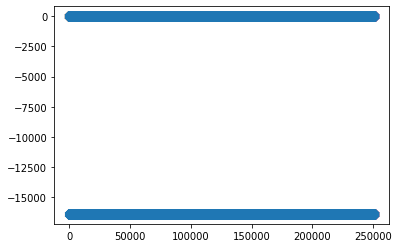

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(list(range(len(ys))), ys, alpha = .002, s = 100)

In [107]:
# !ffmpeg -i '/usr/src/app/radtts/data/JRodriguesNewscastDataset/wavs/195.wav'
!ffmpeg -i '/usr/src/app/radtts/data/lj_data/LJSpeech-1.1/wavs/LJ001-0001.wav'

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

In [127]:
!ffmpeg -i '/usr/src/app/radtts/data/JRodriguesNewscastDataset/wavs/195.wav' -c:a pcm_s16le "output_asdf.wav"

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

In [133]:
read('output_asdf.wav')[1]

array([-1, -1, -1, ...,  0,  0,  0], dtype=int16)

In [130]:
read('/usr/src/app/radtts/data/JRodriguesNewscastDataset/wavs/195.wav')[1]

array([ -76, -133,   -8, ...,  169,  281,    0])

In [131]:
!ffmpeg -i '/usr/src/app/radtts/data/JRodriguesNewscastDataset/wavs/195.wav'

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

In [128]:
ipd.Audio("output_asdf.wav")

In [122]:
!ffmpeg -i '/usr/src/app/radtts/data/JRodriguesNewscastDataset/wavs/195.wav' -f s16le -c:a pcm_s64le '/usr/src/app/radtts/data/JRodriguesNewscastDataset/wavs/195_s16.raw' -y
# !ffmpeg -f '/usr/src/app/radtts/data/JRodriguesNewscastDataset/wavs/195_s16.raw' "output.wav" -y

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

In [115]:
rate , data = read('/usr/src/app/radtts/data/JRodriguesNewscastDataset/wavs/195_s16.wav')

ValueError: File format b'\xb4\xff\xff\xff' not understood. Only 'RIFF' and 'RIFX' supported.

In [25]:
ipd.Audio(rate = rate , data = ys)

In [32]:
ys[:100]

array([     0,      0,      0, -16384,      0,      0,      0, -16384,
            0,      0, -16384, -16384, -16384, -16384, -16384,      0,
       -16384, -16384, -16384,      0, -16384, -16384,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0, -16384,      0,      0,
            0,      0,      0,      0,      0,      0, -16384,      0,
            0,      0, -16384, -16384,      0, -16384,      0,      0,
            0,      0,      0,      0, -16384,      0,      0,      0,
            0,      0, -16384,      0,      0,      0,      0,      0,
       -16384,      0,      0,      0], dtype=int16)

In [68]:
ipd.Audio('/usr/src/app/radtts/data/JRodriguesNewscastDataset/wavs/196.wav')

In [74]:
rate, data = read('/usr/src/app/radtts/data/JRodriguesNewscastDataset/wavs/196.wav')

In [73]:
data.max()

0

In [67]:
ipd.Audio(rate = rate, data = data)

In [69]:
def resample(in_path, output_path):

    resampled_audio = librosa.load(in_path)
    normalized_resampled_audio = np.asarray(
        resampled_audio[0]
        / np.abs(resampled_audio[0]).max()
        * MAX_WAV_VALUE
        / 2,
        dtype=np.int16,
    )
    write(
        data=normalized_resampled_audio,
        rate=resampled_audio[1],
        filename=output_path,
    )

In [70]:
in_path = '/usr/src/app/radtts/data/JRodriguesNewscastDataset/wavs/196.wav'
out_path = '/usr/src/app/radtts/data/JRodriguesNewscastDataset/wavs/196_yourmom.wav'

In [71]:
import librosa
import numpy as np
from scipy.io.wavfile import write
MAX_WAV_VALUE = 32768
resample(in_path, out_path )

/opt/conda/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [92]:
xs = read(in_path)[1]

In [97]:
resampled_audio = librosa.load(in_path, dtype = np.int16)

/opt/conda/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [ ]:
resampled_audio

In [96]:
??librosa.load

In [100]:
ys = resampled_audio[0]

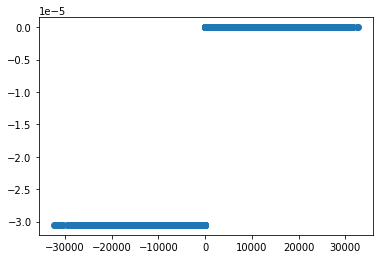

In [101]:
plt.scatter(xs, ys)

In [77]:
resampled_audio[0].max()

0.0

In [61]:
resampled_audio[0].min()

-3.0517578e-05

In [72]:
rate, data = read(out_path)
ipd.Audio(rate = rate, data = data)

In [12]:
len(trainset)

21855

In [ ]:
# ================ MAIN TRAINNIG LOOP! ===================
for q in range(10000):
    i,batch = next(enumerate(train_loader))

    print(q)
    print(batch['audiopaths'])
    tic = timer()
    model.zero_grad()
    (mel, speaker_ids, text, in_lens, out_lens, attn_prior,
     f0, voiced_mask, p_voiced, energy_avg,
     audiopaths) = parse_data_from_batch(batch)

    if iteration >= binarization_start_iter:
        binarize = True   # binarization training phase
    else:
        binarize = False  # no binarization, soft alignments only

#     outputs = model(
#                 mel, speaker_ids, text, in_lens, out_lens,
#                 binarize_attention=binarize, attn_prior=attn_prior,
#                 f0=f0, energy_avg=energy_avg,
#                 voiced_mask=voiced_mask, p_voiced=p_voiced)

    # train(n_gpus, rank, **train_config)

/usr/src/app/radtts/data/Carolyn_Speaking/wavs/183_22k_normalized.wav


/opt/conda/lib/python3.8/site-packages/librosa/core/pitch.py:412: RuntimeWarning: overflow encountered in true_divide
  yin_frames = yin_numerator / (yin_denominator + util.tiny(yin_denominator))
/opt/conda/lib/python3.8/site-packages/librosa/core/pitch.py:432: RuntimeWarning: invalid value encountered in true_divide
  parabolic_shifts[1:-1, :] = -parabola_b / (2 * parabola_a + util.tiny(parabola_a))


/usr/src/app/radtts/data/Carolyn_Speaking/wavs/97_22k_normalized.wav
saving f0 to data_cache/data_Carolyn_Speaking_wavs_97_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt
/usr/src/app/radtts/data/jr_base/wavs/642_22k_normalized.wav
/usr/src/app/radtts/data/Po_Data/wavs/128_22k_normalized.wav
saving f0 to data_cache/data_jr_base_wavs_642_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt
saving f0 to data_cache/data_Po_Data_wavs_128_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt
/usr/src/app/radtts/data/jr_base/wavs/944_22k_normalized.wav
saving f0 to data_cache/data_jr_base_wavs_944_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt
/usr/src/app/radtts/data/jr_base/wavs/304_22k_normalized.wav
/usr/src/app/radtts/data/Carolyn_Speaking/wavs/393_22k_normalized.wav
saving f0 to data_cache/data_Carolyn_Speaking_wavs_393_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt
saving f0 

/opt/conda/lib/python3.8/site-packages/librosa/core/pitch.py:412: RuntimeWarning: overflow encountered in true_divide
  yin_frames = yin_numerator / (yin_denominator + util.tiny(yin_denominator))
/opt/conda/lib/python3.8/site-packages/librosa/core/pitch.py:432: RuntimeWarning: invalid value encountered in true_divide
  parabolic_shifts[1:-1, :] = -parabola_b / (2 * parabola_a + util.tiny(parabola_a))


/usr/src/app/radtts/data/jr_base/wavs/277_22k_normalized.wav
saving f0 to data_cache/data_jr_base_wavs_277_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt
/usr/src/app/radtts/data/Carolyn_Speaking/wavs/231_22k_normalized.wav
saving f0 to data_cache/data_Carolyn_Speaking_wavs_231_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt
/usr/src/app/radtts/data/Po_Data/wavs/68_22k_normalized.wav
saving f0 to data_cache/data_Po_Data_wavs_68_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt
/usr/src/app/radtts/data/JRodriguesOldTimerDataset/wavs/179_22k_normalized.wav


/opt/conda/lib/python3.8/site-packages/librosa/core/pitch.py:412: RuntimeWarning: overflow encountered in true_divide
  yin_frames = yin_numerator / (yin_denominator + util.tiny(yin_denominator))
/opt/conda/lib/python3.8/site-packages/librosa/core/pitch.py:432: RuntimeWarning: invalid value encountered in true_divide
  parabolic_shifts[1:-1, :] = -parabola_b / (2 * parabola_a + util.tiny(parabola_a))


/usr/src/app/radtts/data/Shrek_Data/wavs/130_22k_normalized.wav
saving f0 to data_cache/data_Shrek_Data_wavs_130_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt
/usr/src/app/radtts/data/JRodriguesNewscastDataset/wavs/196_22k_normalized.wav


/opt/conda/lib/python3.8/site-packages/librosa/core/pitch.py:412: RuntimeWarning: overflow encountered in true_divide
  yin_frames = yin_numerator / (yin_denominator + util.tiny(yin_denominator))
/opt/conda/lib/python3.8/site-packages/librosa/core/pitch.py:432: RuntimeWarning: invalid value encountered in true_divide
  parabolic_shifts[1:-1, :] = -parabola_b / (2 * parabola_a + util.tiny(parabola_a))


/usr/src/app/radtts/data/Carolyn_Speaking/wavs/535_22k_normalized.wav
saving f0 to data_cache/data_Carolyn_Speaking_wavs_535_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt
/usr/src/app/radtts/data/Shrek_Data/wavs/94_22k_normalized.wav
saving f0 to data_cache/data_Shrek_Data_wavs_94_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt
/usr/src/app/radtts/data/Po_Data/wavs/226_22k_normalized.wav
saving f0 to data_cache/data_Po_Data_wavs_226_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt
/usr/src/app/radtts/data/jr_base/wavs/581_22k_normalized.wav


/opt/conda/lib/python3.8/site-packages/librosa/core/pitch.py:412: RuntimeWarning: overflow encountered in true_divide
  yin_frames = yin_numerator / (yin_denominator + util.tiny(yin_denominator))
/opt/conda/lib/python3.8/site-packages/librosa/core/pitch.py:432: RuntimeWarning: invalid value encountered in true_divide
  parabolic_shifts[1:-1, :] = -parabola_b / (2 * parabola_a + util.tiny(parabola_a))


/usr/src/app/radtts/data/JRodriguesOldTimerDataset/wavs/61_22k_normalized.wav
saving f0 to data_cache/data_JRodriguesOldTimerDataset_wavs_61_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt
/usr/src/app/radtts/data/jr_base/wavs/463_22k_normalized.wav
saving f0 to data_cache/data_jr_base_wavs_463_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt
/usr/src/app/radtts/data/jr_base/wavs/853_22k_normalized.wav
/usr/src/app/radtts/data/jr_base/wavs/512_22k_normalized.wav


/opt/conda/lib/python3.8/site-packages/librosa/core/pitch.py:412: RuntimeWarning: overflow encountered in true_divide
  yin_frames = yin_numerator / (yin_denominator + util.tiny(yin_denominator))
/opt/conda/lib/python3.8/site-packages/librosa/core/pitch.py:432: RuntimeWarning: invalid value encountered in true_divide
  parabolic_shifts[1:-1, :] = -parabola_b / (2 * parabola_a + util.tiny(parabola_a))


saving f0 to data_cache/data_jr_base_wavs_853_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt
/usr/src/app/radtts/data/jr_base/wavs/137_22k_normalized.wav
saving f0 to data_cache/data_jr_base_wavs_137_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt
/usr/src/app/radtts/data/jr_base/wavs/334_22k_normalized.wav
saving f0 to data_cache/data_jr_base_wavs_334_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt
/usr/src/app/radtts/data/jr_base/wavs/239_22k_normalized.wav
saving f0 to data_cache/data_jr_base_wavs_239_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt
/usr/src/app/radtts/data/jr_base/wavs/623_22k_normalized.wav


/opt/conda/lib/python3.8/site-packages/librosa/core/pitch.py:412: RuntimeWarning: overflow encountered in true_divide
  yin_frames = yin_numerator / (yin_denominator + util.tiny(yin_denominator))
/opt/conda/lib/python3.8/site-packages/librosa/core/pitch.py:432: RuntimeWarning: invalid value encountered in true_divide
  parabolic_shifts[1:-1, :] = -parabola_b / (2 * parabola_a + util.tiny(parabola_a))


/usr/src/app/radtts/data/Po_Data/wavs/79_22k_normalized.wav
saving f0 to data_cache/data_Po_Data_wavs_79_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt
/usr/src/app/radtts/data/Carolyn_Speaking/wavs/521_22k_normalized.wav
saving f0 to data_cache/data_Carolyn_Speaking_wavs_521_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt
/usr/src/app/radtts/data/jr_base/wavs/35_22k_normalized.wav
saving f0 to data_cache/data_jr_base_wavs_35_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt
/usr/src/app/radtts/data/Carolyn_Speaking/wavs/182_22k_normalized.wav
saving f0 to data_cache/data_Carolyn_Speaking_wavs_182_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt
/usr/src/app/radtts/data/jr_base/wavs/298_22k_normalized.wav
saving f0 to data_cache/data_jr_base_wavs_298_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt
/usr/src/app/radtts/data/Po_Data/wavs/132_22k_normalized.wav
/usr/src/app

/opt/conda/lib/python3.8/site-packages/librosa/core/pitch.py:412: RuntimeWarning: overflow encountered in true_divide
  yin_frames = yin_numerator / (yin_denominator + util.tiny(yin_denominator))
/opt/conda/lib/python3.8/site-packages/librosa/core/pitch.py:430: RuntimeWarning: overflow encountered in multiply
  parabola_a = (y_frames[:-2, :] + y_frames[2:, :] - 2 * y_frames[1:-1, :]) / 2
/opt/conda/lib/python3.8/site-packages/librosa/core/pitch.py:432: RuntimeWarning: invalid value encountered in true_divide
  parabolic_shifts[1:-1, :] = -parabola_b / (2 * parabola_a + util.tiny(parabola_a))


/usr/src/app/radtts/data/Shrek_Data/wavs/51_22k_normalized.wav
/usr/src/app/radtts/data/Shrek_Data/wavs/162_22k_normalized.wav
/usr/src/app/radtts/data/Shrek_Data/wavs/264_22k_normalized.wav
saving f0 to data_cache/data_Carolyn_Speaking_wavs_62_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt
saving f0 to data_cache/data_Shrek_Data_wavs_51_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt
saving f0 to data_cache/data_Shrek_Data_wavs_264_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt
saving f0 to data_cache/data_Shrek_Data_wavs_162_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt
/usr/src/app/radtts/data/JRodriguesOldTimerDataset/wavs/58_22k_normalized.wav


/opt/conda/lib/python3.8/site-packages/librosa/core/pitch.py:412: RuntimeWarning: overflow encountered in true_divide
  yin_frames = yin_numerator / (yin_denominator + util.tiny(yin_denominator))
/opt/conda/lib/python3.8/site-packages/librosa/core/pitch.py:432: RuntimeWarning: invalid value encountered in true_divide
  parabolic_shifts[1:-1, :] = -parabola_b / (2 * parabola_a + util.tiny(parabola_a))


/usr/src/app/radtts/data/Carolyn_Speaking/wavs/356_22k_normalized.wav
saving f0 to data_cache/data_Carolyn_Speaking_wavs_356_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt
/usr/src/app/radtts/data/jr_base/wavs/528_22k_normalized.wav
saving f0 to data_cache/data_jr_base_wavs_528_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt
/usr/src/app/radtts/data/Carolyn_Singing/wavs/139_22k_normalized.wav
saving f0 to data_cache/data_Carolyn_Singing_wavs_139_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt
/usr/src/app/radtts/data/Carolyn_Speaking/wavs/360_22k_normalized.wav
saving f0 to data_cache/data_Carolyn_Speaking_wavs_360_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt
/usr/src/app/radtts/data/Shrek_Data/wavs/172_22k_normalized.wav
saving f0 to data_cache/data_Shrek_Data_wavs_172_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt
/usr/src/app/radtts/data/Carolyn_Singing/wavs/1

/opt/conda/lib/python3.8/site-packages/librosa/core/pitch.py:412: RuntimeWarning: overflow encountered in true_divide
  yin_frames = yin_numerator / (yin_denominator + util.tiny(yin_denominator))
/opt/conda/lib/python3.8/site-packages/librosa/core/pitch.py:432: RuntimeWarning: invalid value encountered in true_divide
  parabolic_shifts[1:-1, :] = -parabola_b / (2 * parabola_a + util.tiny(parabola_a))


/usr/src/app/radtts/data/Carolyn_Speaking/wavs/516_22k_normalized.wav
saving f0 to data_cache/data_Carolyn_Speaking_wavs_516_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt
/usr/src/app/radtts/data/jr_base/wavs/376_22k_normalized.wav
saving f0 to data_cache/data_jr_base_wavs_376_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f840642c9d0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1430, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/opt/conda/lib/python3.8/multiprocessing/popen_fork.py", line 44, in wait
    if not wait([self.sentinel], timeout):
  File "/opt/conda/lib/python3.8/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/opt/conda/lib/python3.8/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 


In [25]:
i,batch = next(enumerate(train_loader))

/usr/src/app/radtts/data/JRodriguesOldTimerDataset/wavs/220_22k_normalized.wav
/usr/src/app/radtts/data/Carolyn_Speaking/wavs/381_22k_normalized.wav


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f05e80ed9d0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()


/usr/src/app/radtts/data/Po_Data/wavs/6_22k_normalized.wav

  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers


    if w.is_alive():
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f05e80ed9d0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f05e80ed9d0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/

/usr/src/app/radtts/data/Carolyn_Speaking/wavs/369_22k_normalized.wav


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f05e80ed9d0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f05e80ed9d0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

saving f0 to data_cache/data_JRodriguesOldTimerDataset_wavs_220_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f05e80ed9d0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: 

/usr/src/app/radtts/data/jr_base/wavs/305_22k_normalized.wav

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f05e80ed9d0>


Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


saving f0 to data_cache/data_Carolyn_Speaking_wavs_381_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt
saving f0 to data_cache/data_jr_base_wavs_305_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt
saving f0 to data_cache/data_Po_Data_wavs_6_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.ptsaving f0 to data_cache/data_Carolyn_Speaking_wavs_369_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt

/usr/src/app/radtts/data/michaelchristmas/wavs/60_22k_normalized.wav
saving f0 to data_cache/data_michaelchristmas_wavs_60_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt


In [21]:
from collections import deque

In [23]:
deque(enumerate(train_loader))

/usr/src/app/radtts/data/JRodriguesOldTimerDataset/wavs/254_22k_normalized.wav
/usr/src/app/radtts/data/jr_base/wavs/864_22k_normalized.wav


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f05e80ed9d0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f05e80ed9d0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

/usr/src/app/radtts/data/jr_base/wavs/692_22k_normalized.wav
/usr/src/app/radtts/data/Carolyn_Speaking/wavs/301_22k_normalized.wav
/usr/src/app/radtts/data/Carolyn_Speaking/wavs/263_22k_normalized.wav


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f05e80ed9d0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f05e80ed9d0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

saving f0 to data_cache/data_Carolyn_Speaking_wavs_263_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt
saving f0 to data_cache/data_JRodriguesOldTimerDataset_wavs_254_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt
saving f0 to data_cache/data_jr_base_wavs_864_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt
saving f0 to data_cache/data_jr_base_wavs_692_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt
saving f0 to data_cache/data_Carolyn_Speaking_wavs_301_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt
/usr/src/app/radtts/data/michaelchristmas/wavs/34_22k_normalized.wav
/usr/src/app/radtts/data/Shrek_Data/wavs/161_22k_normalized.wav


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f05e80ed9d0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


/usr/src/app/radtts/data/Shrek_Data/wavs/193_22k_normalized.wav
/usr/src/app/radtts/data/michaelchristmas/wavs/77_22k_normalized.wav
/usr/src/app/radtts/data/Carolyn_Speaking/wavs/278_22k_normalized.wav


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f05e80ed9d0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


saving f0 to data_cache/data_Shrek_Data_wavs_193_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt
saving f0 to data_cache/data_Carolyn_Speaking_wavs_278_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt
saving f0 to data_cache/data_michaelchristmas_wavs_34_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt
saving f0 to data_cache/data_Shrek_Data_wavs_161_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt
/usr/src/app/radtts/data/Carolyn_Speaking/wavs/7_22k_normalized.wav
/usr/src/app/radtts/data/Carolyn_Speaking/wavs/165_22k_normalized.wav
saving f0 to data_cache/data_michaelchristmas_wavs_77_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt
saving f0 to data_cache/data_Carolyn_Speaking_wavs_7_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt
/usr/src/app/radtts/data/Carolyn_Singing/wavs/187_22k_normalized.wav
/usr/src/app/radtts/data/Carolyn_Speaking/wavs/

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f05e80ed9d0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


saving f0 to data_cache/data_Carolyn_Singing_wavs_104_22k_normalized.wav_f0_sr22050_fl1024_hl256_f0min80.0_f0max640.0_log0.pt


KeyboardInterrupt: 

In [12]:
# audiopaths = ['/usr/src/app/radtts/data/dataset-1675696662-bertie/dataset/wavs/285_22k_normalized.wav', '/usr/src/app/radtts/data/lj_data/LJSpeech-1.1/wavs/LJ011-0096_22k_normalized.wav', '/usr/src/app/radtts/data/lj_data/LJSpeech-1.1/wavs/LJ003-0294_22k_normalized.wav', '/usr/src/app/radtts/data/lj_data/LJSpeech-1.1/wavs/LJ004-0026_22k_normalized.wav', '/usr/src/app/radtts/data/lj_data/LJSpeech-1.1/wavs/LJ025-0043_22k_normalized.wav', '/usr/src/app/radtts/data/lj_data/LJSpeech-1.1/wavs/LJ012-0017_22k_normalized.wav', '/usr/src/app/radtts/data/lj_data/LJSpeech-1.1/wavs/LJ006-0180_22k_normalized.wav', '/usr/src/app/radtts/data/eminem/wav22050/341_22k_normalized.wav', '/usr/src/app/radtts/data/lj_data/LJSpeech-1.1/wavs/LJ024-0092_22k_normalized.wav', '/usr/src/app/radtts/data/lj_data/LJSpeech-1.1/wavs/LJ020-0102_22k_normalized.wav', '/usr/src/app/radtts/data/TAG/wavs/233_22k_normalized.wav', '/usr/src/app/radtts/data/lj_data/LJSpeech-1.1/wavs/LJ016-0162_22k_normalized.wav', '/usr/src/app/radtts/data/lj_data/LJSpeech-1.1/wavs/LJ035-0114_22k_normalized.wav', '/usr/src/app/radtts/data/JRodriguesOldTimerDataset/wavs/29_22k_normalized.wav', '/usr/src/app/radtts/data/kanye-rap/wavs/kanye-331_22k_normalized.wav', '/usr/src/app/radtts/data/jr_base/wavs/571_22k_normalized.wav']
import os
[os.path.getsize(filepath) for filepath in batch['audiopaths']]
# attn_prior

[447880,
 406886,
 388966,
 359270,
 350054,
 336742,
 303974,
 246610,
 373606,
 279910,
 165346,
 276326,
 185190,
 188956,
 144692,
 48816]

In [13]:
batch['audiopaths']

['/usr/src/app/radtts/data/dataset-1675696662-bertie/dataset/wavs/285_22k_normalized.wav',
 '/usr/src/app/radtts/data/lj_data/LJSpeech-1.1/wavs/LJ011-0096_22k_normalized.wav',
 '/usr/src/app/radtts/data/lj_data/LJSpeech-1.1/wavs/LJ003-0294_22k_normalized.wav',
 '/usr/src/app/radtts/data/lj_data/LJSpeech-1.1/wavs/LJ004-0026_22k_normalized.wav',
 '/usr/src/app/radtts/data/lj_data/LJSpeech-1.1/wavs/LJ025-0043_22k_normalized.wav',
 '/usr/src/app/radtts/data/lj_data/LJSpeech-1.1/wavs/LJ012-0017_22k_normalized.wav',
 '/usr/src/app/radtts/data/lj_data/LJSpeech-1.1/wavs/LJ006-0180_22k_normalized.wav',
 '/usr/src/app/radtts/data/eminem/wav22050/341_22k_normalized.wav',
 '/usr/src/app/radtts/data/lj_data/LJSpeech-1.1/wavs/LJ024-0092_22k_normalized.wav',
 '/usr/src/app/radtts/data/lj_data/LJSpeech-1.1/wavs/LJ020-0102_22k_normalized.wav',
 '/usr/src/app/radtts/data/TAG/wavs/233_22k_normalized.wav',
 '/usr/src/app/radtts/data/lj_data/LJSpeech-1.1/wavs/LJ016-0162_22k_normalized.wav',
 '/usr/src/app/

In [14]:
batch['text']

tensor([[  8, 182, 131,  ..., 134,   4,   8],
        [  8, 143, 150,  ...,   0,   0,   0],
        [  8,  68,  82,  ...,   0,   0,   0],
        ...,
        [  8,  49,  88,  ...,   0,   0,   0],
        [  8, 125, 111,  ...,   0,   0,   0],
        [  8,  63,  88,  ...,   0,   0,   0]])

In [16]:
from scipy.io.wavfile import read
read('/usr/src/app/radtts/data/jr_base/wavs/571_22k_normalized.wav')[1]

(24386,)

In [17]:
    (mel, speaker_ids, text, in_lens, out_lens, attn_prior,
     f0, voiced_mask, p_voiced, energy_avg,
     audiopaths) = parse_data_from_batch(batch)

In [ ]:
        outputs = model(
                mel, speaker_ids, text, in_lens, out_lens,
                binarize_attention=binarize, attn_prior=attn_prior,
                f0=f0, energy_avg=energy_avg,
                voiced_mask=voiced_mask, p_voiced=p_voiced)

In [7]:
text

tensor([[2314885530818453536, 8313484836034388000, 6640311622669726324, 2819300783829295214, 8028280031318928988, 8315173686074699369,
         2841309738030538793, 2314885530818447882, 8313484836034388000, 2965374326735401588, 2314885530818447911, 7958552634295722016,
         8391155458540399904, 7214801925396105842, 8244230953659033189, 2983190986159054687, 2314885530818447930, 7308345369542074400,
         4404647370985595231, 7810775746299388960, 8314045561160281702, 2314885436484312947, 8391438796303900704, 8316297072636621682,
         6858531898276391028, 3341494402020893791, 732161668137182571, 2314885530818453536, 7310579615589884272, 8316297072636621682,
         6858531898276391028, 7310579615589884272, 2914806860335706994, 2314885530817014057, 7815263158106333216, 8316297072636621669,
         6858531898276391028, 3347130464566800237, 732161668137182571, 2314885530818453536, 2338338411370673506, 8298010352468893757,
         7382915325083675749, 8747515698486601062, 231488

In [7]:
# ================ MAIN TRAINNIG LOOP! ===================
for epoch in range(epoch_offset, epochs):
    print("Epoch: {}".format(epoch))
    for i, batch in enumerate(train_loader):
        print(i)
        print(batch['audiopaths'])
        tic = timer()
        model.zero_grad()
        (mel, speaker_ids, text, in_lens, out_lens, attn_prior,
         f0, voiced_mask, p_voiced, energy_avg,
         audiopaths) = parse_data_from_batch(batch)

        if iteration >= binarization_start_iter:
            binarize = True   # binarization training phase
        else:
            binarize = False  # no binarization, soft alignments only

        with amp.autocast(use_amp):
            
            outputs = model(
                mel, speaker_ids, text, in_lens, out_lens,
                binarize_attention=binarize, attn_prior=attn_prior,
                f0=f0, energy_avg=energy_avg,
                voiced_mask=voiced_mask, p_voiced=p_voiced)
            print(text)
            loss_outputs = criterion(outputs, in_lens, out_lens)

            loss = None
            for k, (v, w) in loss_outputs.items():
                if w > 0:
                    loss = v * w if loss is None else loss + v * w

            w_bin = criterion.loss_weights.get('binarization_loss_weight', 1.0)
            if binarize and iteration >= kl_loss_start_iter:
                binarization_loss = attention_kl_loss(
                    outputs['attn'], outputs['attn_soft'])
                loss += binarization_loss * w_bin
            else:
                binarization_loss = torch.zeros_like(loss)
            loss_outputs['binarization_loss'] = (binarization_loss, w_bin)

        scaler.scale(loss).backward()
        if grad_clip_val > 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(
                model.parameters(), grad_clip_val)
        scaler.step(optimizer)
        scaler.update()

        toc = timer()
        current_lr = optimizer.param_groups[0]['lr']
        print_list = ["iter: {}  ({:.2f} s)  |  lr: {}".format(
            iteration, toc-tic, current_lr)]

        for k, (v, w) in loss_outputs.items():
            reduced_v = reduce_tensor(v, n_gpus, 0).item()
            loss_outputs[k] = reduced_v
            if rank == 0:
                print_list.append('  |  {}: {:.3f}'.format(k, v))
                logger.add_scalar('train/'+k, reduced_v, iteration)

        if rank == 0:
            print(''.join(print_list), flush=True)

        if iteration > -1 and iteration % iters_per_checkpoint == 0:

            val_loss_outputs = compute_validation_loss(
                iteration, model, criterion, valset, collate_fn,
                batch_size, n_gpus, logger=logger,
                train_config=train_config)
            checkpoint_path = "{}/model_{}".format(
                output_directory, iteration)
            save_checkpoint(model, optimizer, learning_rate, iteration,
                            checkpoint_path)
            print('Validation loss:', val_loss_outputs)


        iteration += 1

# train(n_gpus, rank, **train_config)

Epoch: 0
0
['/usr/src/app/radtts/data/lj_data/LJSpeech-1.1/wavs/LJ050-0008_22k_normalized.wav', '/usr/src/app/radtts/data/lj_data/LJSpeech-1.1/wavs/LJ038-0202_22k_normalized.wav', '/usr/src/app/radtts/data/eminem/wav22050/360_22k_normalized.wav', '/usr/src/app/radtts/data/lj_data/LJSpeech-1.1/wavs/LJ027-0031_22k_normalized.wav']
tensor([[  8,  68,  82,  79,   8, 153, 110, 155, 146, 169, 110, 156,   8, 125,
         145, 154, 150, 180, 183,   8,  94,  82,  75,  94,   8,  94,  82,  79,
           8,  92,  79,  77,  89,  87,  87,  79,  88,  78,  79,  78,   8,  51,
          75,  76,  83,  88,  79,  94,  14, 154, 131, 180, 110, 154,   8,  77,
          89,  87,  87,  83,  94,  94,  79,  79,   8,  97,  83,  86,  86,   8,
         143, 131, 154, 166,   8,  94,  89,   8, 153, 134, 131, 153, 170,   8,
         155, 131, 156, 149,   8,  89,  80,   8,  94,  82,  79,   8, 155, 139,
         152, 134,   8, 127, 145, 141, 146, 169, 110, 156, 168, 149, 183,   8,
          89,  80,   8, 168, 179, 166

KeyboardInterrupt: 

In [5]:
text

tensor([[140367447695456, 140367447695456, 94822234982064, 94822234982064, 94822179741344,          0,
         94823112237632, 94821930102416, 140360849129616,          0,          0,          0,
                  0,          0,          0,          1,          0,          0,
                  0,          0,        151,          1, 352947544326148, 4569845219330,
                  1,       1425, 94822234969824, 94822179741328,          0,          0,
         94822179741648,          0, 94823112237632, 94821930102416, 140360849129696,          0,
                  0,          0,          0,          0,          0,          1,
                  0,          0,          0,          0,        152,          1,
         352947544326148, 4569845219330,          4,       1217, 94822234969824, 94822179741632,
                  0,          0, 94822179741952,          0, 94823112237632, 94821930102416,
         140360849129776,          0,          0,          0,          0,          0,
        

In [5]:
            outputs = model(
                mel, speaker_ids, text, in_lens, out_lens,
                binarize_attention=binarize, attn_prior=attn_prior,
                f0=f0, energy_avg=energy_avg,
                voiced_mask=voiced_mask, p_voiced=p_voiced)

RuntimeError: cuDNN error: CUDNN_STATUS_MAPPING_ERROR

In [11]:
text_enc, text_embeddings = model.encode_text(text, in_lens)

RuntimeError: cuDNN error: CUDNN_STATUS_MAPPING_ERROR

In [12]:
text

tensor([[         0,          0,          0,          0,          0,          1,
                  0,          0,          0,          0,        143,          1,
         352947544326148, 4569845219330,         -1,       1569, 93998987496800, 93998987397648,
                  0,          0, 93998987397968,          0, 93998878559776, 93998764242912,
         140695302186224,          0,          0,          0,          0,          0,
                  0,          1,          0,          0,          0,          0,
                144,          1, 352947544326148, 4569845219330,         16,       1361,
         93998987496800, 93998987397952,          0,          0, 93998987398272,          0,
         93998878559776, 93998764242912, 140695302186304,          0,          0,          0,
                  0,          0,          0,          1,          0,          0,
                  0,          0,        145,          1, 352947544326148, 4569845219330,
         7867888722370638651,      

In [10]:
import IPython.display as ipd
ipd.Audio("/usr/src/app/radtts/data/jr_base/wavs/571_22k_normalized.wav")

In [8]:
audiopaths[-1]

'/usr/src/app/radtts/data/jr_base/wavs/571_22k_normalized.wav'

In [6]:
audiopaths = ['/usr/src/app/radtts/data/dataset-1675696662-bertie/dataset/wavs/285_22k_normalized.wav', '/usr/src/app/radtts/data/lj_data/LJSpeech-1.1/wavs/LJ011-0096_22k_normalized.wav', '/usr/src/app/radtts/data/lj_data/LJSpeech-1.1/wavs/LJ003-0294_22k_normalized.wav', '/usr/src/app/radtts/data/lj_data/LJSpeech-1.1/wavs/LJ004-0026_22k_normalized.wav', '/usr/src/app/radtts/data/lj_data/LJSpeech-1.1/wavs/LJ025-0043_22k_normalized.wav', '/usr/src/app/radtts/data/lj_data/LJSpeech-1.1/wavs/LJ012-0017_22k_normalized.wav', '/usr/src/app/radtts/data/lj_data/LJSpeech-1.1/wavs/LJ006-0180_22k_normalized.wav', '/usr/src/app/radtts/data/eminem/wav22050/341_22k_normalized.wav', '/usr/src/app/radtts/data/lj_data/LJSpeech-1.1/wavs/LJ024-0092_22k_normalized.wav', '/usr/src/app/radtts/data/lj_data/LJSpeech-1.1/wavs/LJ020-0102_22k_normalized.wav', '/usr/src/app/radtts/data/TAG/wavs/233_22k_normalized.wav', '/usr/src/app/radtts/data/lj_data/LJSpeech-1.1/wavs/LJ016-0162_22k_normalized.wav', '/usr/src/app/radtts/data/lj_data/LJSpeech-1.1/wavs/LJ035-0114_22k_normalized.wav', '/usr/src/app/radtts/data/JRodriguesOldTimerDataset/wavs/29_22k_normalized.wav', '/usr/src/app/radtts/data/kanye-rap/wavs/kanye-331_22k_normalized.wav', '/usr/src/app/radtts/data/jr_base/wavs/571_22k_normalized.wav']
import os
[os.path.getsize(filepath) for filepath in audiopaths]
# attn_prior

[447880,
 406886,
 388966,
 359270,
 350054,
 336742,
 303974,
 246610,
 373606,
 279910,
 165346,
 276326,
 185190,
 188956,
 144692,
 48816]

In [42]:
batch['audiopaths']

['/usr/src/app/radtts/data/lj_data/LJSpeech-1.1/wavs/LJ033-0161_22k_normalized.wav',
 '/usr/src/app/radtts/data/lj_data/LJSpeech-1.1/wavs/LJ019-0312_22k_normalized.wav',
 '/usr/src/app/radtts/data/eminem/wav22050/261_22k_normalized.wav',
 '/usr/src/app/radtts/data/Carolyn_Singing/wavs/261_22k_normalized.wav']

In [8]:
batch['text']

tensor([[  8,  94,  82,  79,   8, 181, 115, 154,   8, 125, 145, 156, 150, 171,
           8,  75,  88,  78,   8, 110, 125, 111, 180,   8,  83,  94,   8,  97,
          75,  93,   8,  92,  95,  93,  94,  83,  77,  75,  94,  79,  78,   3,
           8,  83,  88,   8, 111, 128, 134,   8, 181, 135, 127, 183,   3,   8,
          94,  82,  79,   8, 142, 167, 107, 156, 145, 170,   8, 168, 135, 141,
         110, 168,   8, 143, 107, 127,   8, 125, 145, 153, 111, 155,   8,  92,
          89,  95,  81,  82,  79,  88,  79,  78,   3,   8,  75,  88,  78,   8,
         115, 141, 134, 127,   8,  75,   8, 168, 115, 167, 170,   8,  89,  80,
           8, 141, 174, 170, 143, 161, 154, 127,   4,   8],
        [  8,  83,  80,   8,  94,  82,  79,   8, 154, 131, 152, 110, 168, 154,
         140, 170, 145, 180,   8, 166, 119, 134,   8,  83,  93,   8, 156, 103,
         170,   8, 154, 131, 141, 170,   8, 141, 167, 150,   8,  94,  89,   8,
         126, 178, 183,   8,  94,  82,  79,   8, 155, 131, 171, 110, 12

In [18]:
text  = batch['text'].cuda()
in_lens = batch['input_lengths'].cuda()

In [ ]:
input_lengths, ids_sorted_decreasing = torch.sort(
    torch.LongTensor([len(x["text_encoded"]) for x in batch]),
    dim=0,
    descending=True,
)